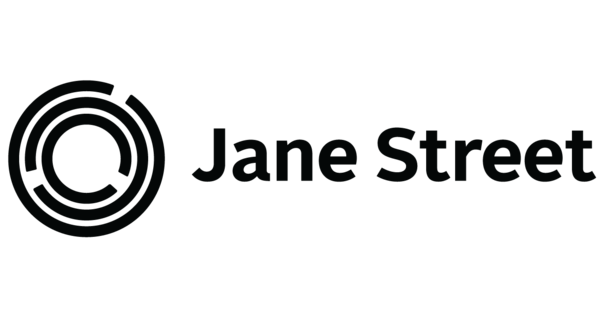

### Dueling Double Deep Q-Learning
by Alin Cijov

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.distributions import Categorical

import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if device == 'cuda': import cudf

# Prepare Data

In [ ]:
path = '/kaggle/input/jane-street-market-prediction/train.csv'

In [ ]:
def load_df(path, device):
    if device == 'cuda':
        df = cudf.read_csv(path)
    else:
        df = pd.read_csv(path)
        
    features = [column for column in df.columns if 'feature' in column]
    
    return df, features


# load data and features
df, features = load_df(path, device)

In [ ]:
def add_actions(df, features, device):
    f_mean = df[features[1:]].mean()
    f_std = df[features[1:]].std()
    
    df = df.query('weight > 0').reset_index(drop = True)
    df[features[1:]] = df[features[1:]].fillna(f_mean)
    df[features[1:]] = (df[features[1:]] - f_mean) / f_std
    df['action'] = (df['resp'] > 0).astype('int')
    
    if device == 'cuda': df = df.to_pandas()
    
    return df


# add the action column
df = add_actions(df, features, device)

# Environment

In [ ]:
class Env:
    def __init__(self, df, features):
        self.n_samples = df.shape[0]
        self.weight = torch.FloatTensor(df['weight'].values)
        self.resp = torch.FloatTensor(df['resp'].values)
        self.states = torch.FloatTensor(df[features].values)
        self.observation_space = df[features].shape[1]
        self.action_space = 2
        self.idx = 0
        
    def reset(self):
        self.idx = 0
        return self.states[self.idx].view(1, -1)
    
    def step(self, action):
        reward = self.weight[self.idx] * self.resp[self.idx] * action
        self.idx += 1
        if self.idx >= self.n_samples:
            done = True
            self.idx = 0
        else:
            done = False
        info = 0
        return self.states[self.idx].view(1, -1), reward, done, info

# Configurations

In [ ]:
class Config:
    def __init__(self, 
                 epsilon_start = 1.,
                 epsilon_final = 0.01,
                 epsilon_decay = 8000,
                 gamma = 0.99, 
                 lr = 1e-4, 
                 target_net_update_freq = 1000, 
                 memory_size = 100000, 
                 batch_size = 128, 
                 learning_starts = 5000,
                 max_frames = 10000000): 

        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.epsilon_by_frame = lambda i: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * i / self.epsilon_decay)

        self.gamma =gamma
        self.lr =lr

        self.target_net_update_freq =target_net_update_freq
        self.memory_size =memory_size
        self.batch_size =batch_size

        self.learning_starts = learning_starts
        self.max_frames = max_frames

# Experience Replay

In [ ]:
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        next_states = [] 
        dones = []

        for b in batch: 
            states.append(b[0])
            actions.append(b[1])
            rewards.append(b[2])
            next_states.append(b[3])
            dones.append(b[4])

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

# Dueling Network 

In [ ]:
class DuelingNetwork(nn.Module): 
    def __init__(self, obs, ac): 
        super().__init__()
        self.model = nn.Sequential(nn.utils.weight_norm(nn.Linear(obs, 512)),
                                   nn.ReLU(), 
                                   nn.utils.weight_norm(nn.Linear(512, 256)),
                                   nn.ReLU())

        self.value_head = nn.utils.weight_norm(nn.Linear(256, 1))
        self.adv_head = nn.utils.weight_norm(nn.Linear(256, ac))

    def forward(self, x): 
        out = self.model(x)

        value = self.value_head(out)
        adv = self.adv_head(out)

        q_val = value + adv - adv.mean(1).reshape(-1,1)
        return q_val

# Dueling DDQN

In [ ]:
class DuelingDDQN(nn.Module): 
    def __init__(self, obs, ac, config): 
        super().__init__()

        self.q = DuelingNetwork(obs, ac).to(device)
        self.target = DuelingNetwork(obs, ac).to(device)

        self.target.load_state_dict(self.q.state_dict())

        self.target_net_update_freq = config.target_net_update_freq
        self.update_counter = 0

    def get_action(self, x):
        x = torch.FloatTensor(x).to(device)
        with torch.no_grad(): 
            a = self.q(x).max(1)[1]

        return a.item()

    def update_policy(self, adam, memory, params): 
        b_states, b_actions, b_rewards, b_next_states, b_masks = memory.sample(params.batch_size)

        states = torch.FloatTensor(b_states).to(device)
        actions = torch.LongTensor(b_actions).reshape(-1,1).to(device)
        rewards = torch.FloatTensor(b_rewards).reshape(-1,1).to(device)
        next_states = torch.FloatTensor(b_next_states).to(device)
        masks = torch.FloatTensor(b_masks).reshape(-1,1).to(device)

        current_q_values = self.q(states).gather(1, actions)

        with torch.no_grad():
            max_next_q_vals = self.target(next_states).max(1)[0].reshape(-1,1)

        expected_q_vals = rewards + max_next_q_vals * 0.99 * masks

        loss = F.mse_loss(expected_q_vals, current_q_values)
        
        adam.zero_grad()
        loss.backward()

        for p in self.q.parameters(): 
            p.grad.data.clamp_(-1.,1.)
        adam.step()

        self.update_counter += 1
        if self.update_counter % self.target_net_update_freq == 0: 
            self.update_counter = 0 
            self.target.load_state_dict(self.q.state_dict())

# Training

In [ ]:
env = Env(df, features)       
config = Config(epsilon_start = 1.,
                epsilon_final = 0.01,
                epsilon_decay = 8000,
                gamma = 0.99, 
                lr = 1e-4, 
                target_net_update_freq = 1000, 
                memory_size = env.n_samples // 100, 
                batch_size = 128, 
                learning_starts = 5000,
                max_frames = env.n_samples)
memory = ExperienceReplay(config.memory_size)
agent = DuelingDDQN(env.observation_space, env.action_space, config)
adam = optim.Adam(agent.q.parameters(), lr = config.lr) 

In [ ]:
s = env.reset()
ep_reward = 0. 
recap = []
rewards = []

p_bar = tqdm(total = config.max_frames)
for frame in range(config.max_frames):

    epsilon = config.epsilon_by_frame(frame)

    if np.random.random() > epsilon: 
        action = agent.get_action(s)
    else: 
        action = np.random.randint(0, env.action_space)

    ns, r, done, infos = env.step(action)
    ep_reward += r 
    if done:
        ns = env.reset()
        recap.append(ep_reward)
        p_bar.set_description('Rew: {:.3f}'.format(ep_reward))
        ep_reward = 0.

    memory.push((s.reshape(-1).numpy().tolist(), action, r, ns.reshape(-1).numpy().tolist(), 0. if done else 1.))
    s = ns  

    p_bar.update(1)

    if frame > config.learning_starts:
        agent.update_policy(adam, memory, config)

    if frame % 1000 == 0:
        print(f'{frame + 1}/{config.max_frames}:', ep_reward, end = '\r')
        rewards.append(ep_reward.item())

p_bar.close()

# Analyze

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Rewards per Episode")
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")

# Credits

[Dueling DDQN Github Implementation](https://github.com/MoMe36/DuelingDDQN)